In [1]:
import requests
import re
import os
import time
import math
import pandas as pd
import numpy as np
import urllib.parse as urp
from bs4 import BeautifulSoup 
from urllib import request
from copy import deepcopy
from xml.etree import ElementTree
from bs4 import BeautifulSoup
import networkx as nx
%matplotlib inline


"""
从百度api获取给定车站的坐标
"""
class GetInfo:
    def __init__(self,df):
        self.__data__ = df
    def get_location(self):
        self.__data__['lng'] = np.nan
        self.__data__['lat'] = np.nan
        for i in self.__data__.index:
            self.__data__.loc[i,'lat'],self.__data__.loc[i,'lng'] = self.__get_location1__(self.__data__.loc[i,'name'],self.__data__.loc[i,'city'])
        return self.__data__
    def __get_location1__(self,name,city):
        my_ak = 'gxB9Y6SdvED78vddAYI3psLH'
        tag = urp.quote('地铁站')
        qurey = urp.quote(name)
        try:
            url = 'http://api.map.baidu.com/place/v2/search?query='+qurey+'&tag='+'&region='+urp.quote(city)+'&output=json&ak='+my_ak
            req = request.urlopen(url)
            time.sleep(0.05)
            res = req.read().decode()
            lat = pd.to_numeric(re.findall('"lat":(.*)',res)[0].split(',')[0])
            lng = pd.to_numeric(re.findall('"lng":(.*)',res)[0])
            return lat,lng
        except:
            return 0,0
  
"""根据两点坐标获取两点之间距离"""
def geo_distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d
      
"""输入起点与终点和搜索策略，得到最优路线"""
def search(start, destination, connection_grpah, sort_candidate):
    pathes = [[start]] 
    visitied = set()
    
    while pathes: # if we find existing pathes
        path = pathes.pop(0)
        froninter = path[-1]
        
        if froninter in visitied: continue
            
        successors = connection_grpah[froninter]
        
        for city in successors:
            if city in path: continue  # eliminate loop
                
            new_path = path + [city]
            
            pathes.append(new_path)
            
            if city == destination: return new_path
        
        visitied.add(froninter)
        pathes = sort_candidate(pathes) # 我们可以加一个排序函数 对我们的搜索策略进行控制

        
"""站点最少搜索策略"""
def transfer_stations_first(pathes): 
    return sorted(pathes, key=len)

"""距离最小搜索策略"""

def get_geo_distance(city1, city2):
    return geo_distance(city_location[city1], city_location[city2])

def shortest_path_first(pathes):
    
    if len(pathes) <= 1: return pathes
    
    def get_path_distnace(path):
        distance = 0
        for station in path[:-1]:
            distance += get_geo_distance(station, path[-1])
            
        return distance

    return sorted(pathes, key=get_path_distnace)
    
"""得到线路名称"""
def get_txt_name():
    txt_src_name = []
    for i in range(5, 10):
        txt_src_name += soup.find_all('td', {'colspan': str(i)})
    return txt_src_name

"""得到可用的线路名称"""
def get_txtuseful_name():
    obj = []
    for each in get_txt_name():
        obj += re.findall(r">(.+)<", str(each))
    return obj   

"""获取线路的具体信息"""
def get_stationinfo():
    Stationinfo = soup.find_all('tbody') 
    obj = []
    for each in Stationinfo:
        temp = re.findall(r">(.+?)<", str(each))   
        obj += temp
    return obj


公主坟->莲花桥->六里桥->六里桥东->北京西站->军事博物馆


d:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


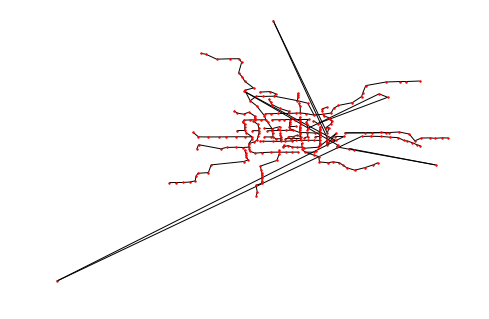

In [3]:
# 1、 从网站获取数据
url = "http://www.bjsubway.com/station/zjgls/"
response = requests.get(url)
response.encoding = "gbk"
html = response.text
soup = BeautifulSoup(html, 'lxml')
station = get_stationinfo()

# 2、处理从网站得来的数据，构造地铁站相互连接关系的集合.
station_info = re.findall(r"'(\w+)——(\w+)',\s'(\d+)'" , str(station))
start_pos = []
end_pos = []
distance = []
station = {}

for content in station_info:  # 获得当前站与下一站地铁站关系的集合
    start, end, pos = content
    start_pos.append(content[0])
    end_pos.append(content[1])
    distance.append(content[2])
    station[start] = [end]
    
station_temp = deepcopy(station)  #  获得地铁站完整的名字集合

for key in station:
    if station[key][0] not in station.keys():
        newkey = station[key][0]
        station_temp[newkey] = [key]
         
station_all = deepcopy(station_temp)  # 获得完整地铁站与上下地铁站关系的集合  

for key1 in station_temp:
    for key2 in station_temp:
        if station_temp[key1] == [key2]:
            station_all[key2].append(key1)
            
# 3、构造地图输入数据,获取地铁站坐标
city_data = {}
city_name = []
for key in station_all:
    city_name.append(key)
city_data = {'city': ["北京"]*len(city_name), # 构建类的输入数据
             'name': city_name
             }
city_df = pd.DataFrame(city_data)

Beijing_station = GetInfo(city_df)  # 实例化类，获得站点坐标信息
location_df = Beijing_station.get_location()

location_df.to_csv('./station_location.csv',index = False)  # 保存站点坐标信息csv文件
subway_location = pd.read_csv('station_location.csv')           

subway_location_dic = {}  # 构建networkx输入数据
for index, row in subway_location.iterrows():
    subway_location_dic[row['name']] = (float(row['lng']),float(row['lat']))
    
# 4、可视化处理后的地铁站数据
subway_graph = nx.Graph(station_all)
nx.draw(subway_graph,subway_location_dic, node_size=2)

# 5、得到最优乘坐路线
optimal_path = search('公主坟', '军事博物馆', station_all, sort_candidate=transfer_stations_first)
print('->'.join(optimal_path))